# Border Geometry
This notebook:
- Imports data on the borders of Central American Countries
- Computes the convex hull of the the borders 
- Resolves overlap issues through Latitudinal priority (More northern country )
- Visualizes the new country border geometries
- Discerns which of the edges in convex hull representation border the ocean 
- Computes the *inital velocity normal* vector of each country by computing a weighted average of the normals to the edges which border the ocean
- Saves a CSV file with the nodes of each country's border and the inital velocity normal

In [32]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from shapely.geometry import Polygon, Point, LineString
from shapely.ops import unary_union

## Import and Filter Data

In [33]:
# Load the Natural Earth Admin 0 shapefile.
world = gpd.read_file("natural_earth/ne_50m_admin_0_countries.shp")

# Define the list of Central American countries.
countries = ["Belize", "Costa Rica", "El Salvador", "Guatemala", 
             "Honduras", "Nicaragua", "Panama"]
central_america = world[world["ADMIN"].isin(countries)].copy()

## Compute Convex Hull of Each Country

In [34]:
# Create a column that holds the convex hull of each country's geometry.
central_america["convex_hull"] = central_america["geometry"].convex_hull

## Resolve Overlap Issues via Latitudinal Priority

In [35]:
# For overlapping convex hulls, the more northern country gets priority.
# Compute the centroid latitude for each convex hull.
central_america["centroid_lat"] = central_america["convex_hull"].centroid.y

# Sort countries by descending centroid latitude (more northern first).
central_america.sort_values("centroid_lat", ascending=False, inplace=True)

# Initialize the adjusted geometry column with the original convex hull.
central_america["adjusted_geom"] = central_america["convex_hull"]

# Iterate over the sorted countries.
# For each lower-priority (i.e. more southern) country, subtract out areas that
# overlap with any of the already processed (more northern) countries.
processed_union = None
for idx, row in central_america.iterrows():
    geom = row["adjusted_geom"]
    if processed_union is not None:
        # Remove any overlap with higher-priority countries.
        geom = geom.difference(processed_union)
    # Save the adjusted geometry.
    central_america.at[idx, "adjusted_geom"] = geom
    # Update the union of already processed (higher priority) geometries.
    if processed_union is None:
        processed_union = geom
    else:
        processed_union = unary_union([processed_union, geom])

/var/folders/2f/7sxq51rj0xd8mgyvzzj2tgy80000gn/T/ipykernel_63306/1378301060.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  central_america["centroid_lat"] = central_america["convex_hull"].centroid.y


## Visualize Adjusted Geometries

/var/folders/2f/7sxq51rj0xd8mgyvzzj2tgy80000gn/T/ipykernel_63306/1094091029.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("tab10", len(central_america))


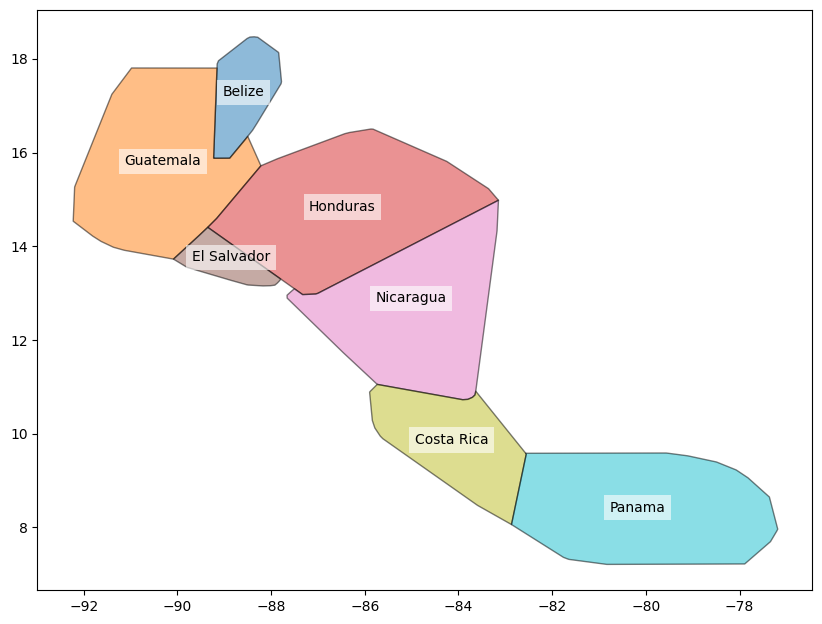

In [36]:
fig, ax = plt.subplots(figsize=(10, 8))

# Use a colormap to assign a unique color for each country.
cmap = cm.get_cmap("tab10", len(central_america))
for i, (idx, row) in enumerate(central_america.iterrows()):
    country = row["ADMIN"]
    geom = row["adjusted_geom"]
    color = cmap(i)
    # Plot the adjusted (overlap-resolved) country border.
    gpd.GeoSeries(geom).plot(ax=ax, color=color, edgecolor='black', alpha=0.5)
    # Label the country at the centroid of its original convex hull.
    centroid = row["convex_hull"].centroid
    ax.text(centroid.x, centroid.y, country,
            fontsize=10, ha='center', va='center',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

## Discern Ocean Border Edges

/var/folders/2f/7sxq51rj0xd8mgyvzzj2tgy80000gn/T/ipykernel_63306/225212849.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("tab10", len(central_america))


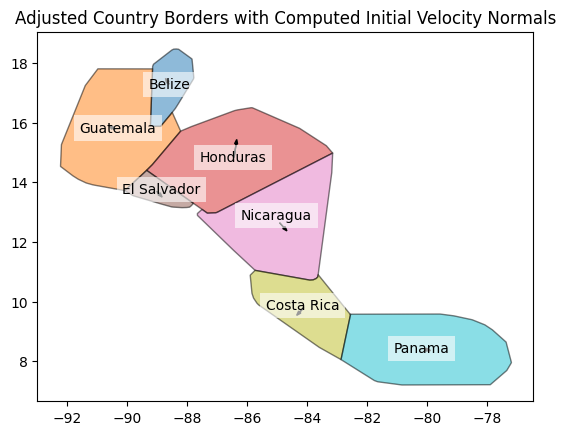

In [ ]:
# Get the current axes.
ax = plt.gca()  # This ensures that 'ax' is defined

# Use a colormap to assign a unique color for each country.
cmap = cm.get_cmap("tab10", len(central_america))
for i, (idx, row) in enumerate(central_america.iterrows()):
    country = row["ADMIN"]
    geom = row["adjusted_geom"]
    color = cmap(i)
    # Plot the adjusted (overlap-resolved) country border.
    gpd.GeoSeries(geom).plot(ax=ax, color=color, edgecolor='black', alpha=0.5)
    # Label the country at the centroid of its original convex hull.
    centroid = row["convex_hull"].centroid
    ax.text(centroid.x, centroid.y, country,
            fontsize=10, ha='center', va='center',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

# Compute the union of all adjusted country geometries.
all_union = unary_union(central_america["adjusted_geom"].tolist())
# The external boundary of this union is the overall ocean boundary.
ocean_boundary = all_union.boundary

# Set the tolerance and small offset.
tol = 1e-6      # tolerance for geometric comparisons
epsilon = 0.01  # small distance for testing normal direction

# Create a dictionary to store the computed normal for each country.
velocity_normals = {}

for idx, row in central_america.iterrows():
    country = row["ADMIN"]
    geom = row["adjusted_geom"]
    # In case the adjusted geometry is a MultiPolygon, choose the largest polygon.
    if geom.geom_type == "MultiPolygon":
        geoms = list(geom.geoms)
        geom = max(geoms, key=lambda g: g.area)
    # Get exterior coordinates.
    coords = list(geom.exterior.coords)
    
    total_weight = 0.0
    normal_sum = [0.0, 0.0]
    
    # Loop over each segment (pair of consecutive coordinates).
    for i in range(len(coords) - 1):
        p1 = coords[i]
        p2 = coords[i + 1]
        segment = LineString([p1, p2])
        # Compute how much of the segment is in contact with water.
        water_intersection = segment.intersection(ocean_boundary)
        water_length = water_intersection.length if not water_intersection.is_empty else 0.0
        if water_length > tol:
            # Compute edge vector.
            dx = p2[0] - p1[0]
            dy = p2[1] - p1[1]
            seg_length = (dx**2 + dy**2)**0.5
            if seg_length == 0:
                continue
            # Use the water-contact length as the weight.
            weight = water_length
            # For a CCW polygon, the interior is to the left, so candidate outward normal
            # is a 90° clockwise rotation: (dy, -dx).
            nx = dy / seg_length
            ny = -dx / seg_length
            # Test whether this normal is pointing outward.
            midx = (p1[0] + p2[0]) / 2.0
            midy = (p1[1] + p2[1]) / 2.0
            test_point = Point(midx + epsilon * nx, midy + epsilon * ny)
            if geom.contains(test_point):
                nx, ny = -nx, -ny
            # Accumulate the weighted normal (weight = water_length).
            total_weight += weight
            normal_sum[0] += nx * weight
            normal_sum[1] += ny * weight

    # Compute the weighted average normal.
    if total_weight > 0:
        avg_normal = (normal_sum[0] / total_weight, normal_sum[1] / total_weight)
    else:
        avg_normal = (0.0, 0.0)
    velocity_normals[country] = avg_normal

    # For visualization, plot an arrow representing the normal at the polygon's centroid.
    centroid = geom.centroid
    ax.arrow(centroid.x, centroid.y, avg_normal[0] * 0.5, avg_normal[1] * 0.5,
             head_width=0.1, fc='k', ec='k')
    

plt.title("Adjusted Country Borders with Computed Initial Velocity Normals")
plt.axis("equal")
plt.show()

## Export CSV with Border Nodes and Initial Velocity Normal

In [38]:
csv_rows = []
for idx, row in central_america.iterrows():
    country = row["ADMIN"]
    geom = row["adjusted_geom"]
    # If multipolygon, pick the largest component.
    if geom.geom_type == "MultiPolygon":
        geoms = list(geom.geoms)
        geom = max(geoms, key=lambda g: g.area)
    # Get the exterior coordinates of the polygon.
    coords = list(geom.exterior.coords)
    # Get the computed velocity normal for this country.
    vnorm = velocity_normals[country]
    # For each coordinate, add a row. (The computed normal is repeated for all nodes.)
    for lon, lat in coords:
        csv_rows.append({
            "country": country,
            "longitude": lon,
            "latitude": lat,
            "vnorm_x": vnorm[0],
            "vnorm_y": vnorm[1]
        })

# Convert the list to a DataFrame and save as CSV.
df_out = pd.DataFrame(csv_rows)
csv_filename = "central_america_border_nodes_with_velocity_normal.csv"
df_out.to_csv(csv_filename, index=False)
print(f"CSV saved: {csv_filename}")


CSV saved: central_america_border_nodes_with_velocity_normal.csv
